In [1]:
%cd /qbio/nest/ari/works/hcmv/hcmv_ont

/qbio/ari/works/hcmv/hcmv_ont


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from functools import partial
from Bio import Seq
from Bio import SeqIO

In [4]:
lnccolors = {
    'RNA2.7': [2362, 4874, '#82c91e', '-'],
    'RNA1.2': [6634, 7684, '#ffd43b', '-'],
    'RNA4.9': [93949, 98873, '#3bc9db', '+'],
    'RNA5.0': [155744,  161422 , '#e64980', '-'],
}

lncanno = pd.DataFrame(lnccolors,
                      index='start end color strand'.split(' '))
                      #columns=['name', 'start', 'end', 'color'])
lncanno = lncanno.T
lncanno

,start,end,color,strand
RNA2.7,2362,4874,#82c91e,-
RNA1.2,6634,7684,#ffd43b,-
RNA4.9,93949,98873,#3bc9db,+
RNA5.0,155744,161422,#e64980,-


In [5]:
MIN_COV = 100
MIN_ODDR = 1.8
AGG_DIS = 4
MIN_MODFRAC = 0.3
MAX_PVALUE = 0.001

In [6]:
sample_names = 'latent react lytic'.split(' ')
reference_sequence = '../refs/HCMV-Toledo.fasta'
refseq = str(next(SeqIO.parse(reference_sequence, 'fasta')).seq).upper().replace('T', 'U')

In [7]:
def load_combine_all(filelist, samples):
    modfracs = []
    for file, name in zip(filelist, samples):
        stats = pd.read_csv(file, sep = '\t')
        stats['sample'] = name
        modfracs.append(stats)
    
    modfracs = pd.concat(modfracs).sort_values(by=['start_loc', 'sample'])
    return(modfracs)

def get_modified_sites(filelist, samples, pvalue=0.05, hp_filter=True):
    positive_positions = set()
    for file, name in zip(filelist, samples):
        stats = pd.read_csv(file, sep = '\t')
        if hp_filter:
            stats = stats[stats['homo_seq']=='--']

        stats_high = stats[(stats['total_reads'] >= MIN_COV) &
                               (stats['oddR'] >= MIN_ODDR) &
                          (stats['pval']<=MAX_PVALUE)&
                          (stats['ESB_test']>=0.05)]
        positive_positions |= set(stats_high['start_loc'].tolist())
    
    modfracs=[]
    for file, name in zip(filelist, samples):
        stats = pd.read_csv(file, sep = '\t')
        stats['sample'] = name
        modfracs.append(stats[stats['start_loc'].isin(positive_positions)])
        
    
    if len(modfracs) > 0:
        ret = pd.concat(modfracs).sort_values(by=['start_loc', 'sample']).reset_index(drop=True)
        return ret

def aggregate_adjacent_sites(modfracs, max_distance, minimum_coverage):
    modsites_raw = sorted(modfracs['start_loc'].unique())
    continuity = np.diff(modsites_raw) <= max_distance

    modsite_groups = [[modsites_raw.pop(0)]]
    for pos, cont in zip(modsites_raw, continuity):
        if cont:
            modsite_groups[-1].append(pos)
        else:
            modsite_groups.append([pos])

    purified = []
    for modsites in modsite_groups:
        modfracsites = modfracs[modfracs['start_loc'].isin(modsites)]

        modfracsites_high = modfracsites[modfracsites['total_reads'] >= minimum_coverage]
        maxpos = modfracsites.loc[modfracsites_high['oddR'].idxmax()]
        purified.append(modfracsites[modfracsites['start_loc'] == maxpos['start_loc']])

    return pd.concat(purified)



modfracs = load_combine_all(
    [f'eligos2/pairdiff2/hcmv_{name}/combine.txt' for name in sample_names],
              sample_names)

eligos2_freqmods = get_modified_sites(
    [f'eligos2/pairdiff2/hcmv_{name}/combine.txt' for name in sample_names],
              sample_names, pvalue=MAX_PVALUE)



eligos2_psites = aggregate_adjacent_sites(eligos2_freqmods, AGG_DIS, MIN_COV)
def identify_position(p, anno):
    matching = anno[(anno['start']-1 <= p) & (p < anno['end']+1)]
    return(matching.index.tolist()[0])
def summarize_into_table(aggrtbl):
    mod_frac_all = pd.pivot_table(aggrtbl, columns='sample', values=['oddR'],
                                 index=['start_loc', 'strand']).fillna(0)['oddR'].copy()
    coverage = pd.pivot_table(aggrtbl, columns='sample', values=['total_reads'],
                             index=['start_loc', 'strand']).fillna(0)['total_reads'].copy()
    esb = pd.pivot_table(aggrtbl, columns='sample', values=['ESB_test'],
                             index=['start_loc', 'strand']).fillna(0)['ESB_test'].copy()
    return esb, mod_frac_all, coverage

def add_context_info(sitemodfrac, refseq, flanksize, lncanno):
    context_list=[]
    for pos, strand in sitemodfrac.index:

        context=refseq[pos-flanksize:pos].lower() + refseq[pos:pos+1].upper()+ refseq[pos+1:pos+1+flanksize].lower()
        if strand =='-':
            context = str(Seq.Seq(context).reverse_complement())
        else:
            context = context
        context_list.append(context)
        
    return(context_list)


eligos2_esb, eligos2_sitemodfrac, eligos2_sitecov= summarize_into_table(eligos2_psites)


eligos2_sitemodfrac['lnc'] = [identify_position(p,lncanno) for p in np.array(list(eligos2_sitemodfrac.index))[:,0].astype(int)]
eligos2_sitemodfrac['context'] = add_context_info(eligos2_sitemodfrac, refseq, 10, lncanno)
eligos2_sitemodfrac = eligos2_sitemodfrac.reset_index().set_index('start_loc')
eligos2_sitemodfrac[eligos2_sitemodfrac['lnc']!='RNA5.0']

sample,strand,latent,lytic,react,lnc,context
start_loc,,,,,,
2361,-,2.691567,5.512133,3.492105,RNA2.7,guuugcaugcAuuugccgugu
2452,-,1.997827,1.853122,2.040749,RNA2.7,uaaucuauuaUuuuguuccuu
2649,-,11.499408,12.129549,10.379227,RNA2.7,ucgugagaacUuugagauucg
2668,-,3.993043,4.166196,3.916033,RNA2.7,auucuugaagAcaauauucuc
2691,-,2.443807,2.988518,3.312116,RNA2.7,aaaaucuuggAccacaguugu
2709,-,6.007200,5.460003,6.289067,RNA2.7,accuaaaaagAccaaaaaaaa
2921,-,3.473871,3.048512,3.466441,RNA2.7,uacaccuagaGacagcccuua
3018,-,1.427286,1.795905,2.032633,RNA2.7,ccaaugcaauCuugucucggc
3037,-,1.147611,1.390942,1.864067,RNA2.7,cguuuuugaaAcaguucagcc


In [8]:
def meme(posdf):
    with open('temp_fasta.fa', 'w') as outpfile:
        for _, line in posdf.iterrows():
            strand = line['strand']
            pos = _
            flanksize = 10
            context=refseq[pos-flanksize:pos].lower() + refseq[pos:pos+1].upper()+ refseq[pos+1:pos+1+flanksize].lower()
            if strand =='-':
                context = str(Seq.Seq(context).reverse_complement())
            else:
                context = context
            print(f'>{pos},{strand}', file=outpfile)
            print(context, file=outpfile)

The output directory 'meme_all3/' already exists.
Its contents will be overwritten.
CD: cefrac 0.25 length 21 central region 4
BACKGROUND: using background model of order 0
PRIMARY (cd): n 38 p0 19 p1 9 p2 10
SEQUENCE GROUP USAGE-- Starts/EM: p0; Trim: p1; pvalue: p2; nsites: p0,p1,p2
Option '-maxw' is greather than the length of longest sequence (21).  Setting '-maxw' to 21.
SEEDS: maxwords 798 highwater mark: seq 38 pos 16
BALANCE: samples 38 chars 798 nodes 1 chars/node 798

seqs=    38, min_w=  21, max_w=   21, total_size=      798

motif=1
SEED DEPTHS: 2 4 8 16 19
SEED WIDTHS: 5 7 9 12 16 21
em: w=  12, psites=  19, iter=  30 



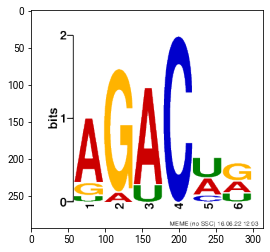

In [11]:
meme(eligos2_sitemodfrac[eligos2_sitemodfrac['lnc']!='RNA5.0'])
!conda run -n meme meme temp_fasta.fa -oc meme_all3/ -rna -minw 5 -objfun cd -mod zoops

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('meme_all3/logo1.png')
imgplot = plt.imshow(img)


In [10]:
from io import StringIO

In [12]:
memealn = pd.read_csv(StringIO(
"""98152,+                           0.00023  10_[1]_5
97603,+                           0.00023  8_[1]_7
2921,-                             0.0005  9_[1]_6
6940,-                            0.00083  8_[1]_7
6670,-                            0.00083  7_[1]_8
2668,-                             0.0017  8_[1]_7
4276,-                             0.0021  10_[1]_5
95764,+                            0.0026  8_[1]_7
2709,-                             0.0031  8_[1]_7
97089,+                             0.004  8_[1]_7
97747,+                            0.0047  8_[1]_7
93979,+                             0.006  13_[1]_2
7011,-                              0.006  11_[1]_4
3771,-                             0.0067  6_[1]_9
7287,-                              0.008  8_[1]_7
3037,-                              0.008  8_[1]_7
7166,-                             0.0085  7_[1]_8
2452,-                              0.019  1_[1]_14
97656,+                             0.046  5_[1]_10
4834,-                              0.046  2_[1]_13
6649,-                              0.078  7_[1]_8
"""),delim_whitespace=True, names='start_loc pvalue diagram'.split(' '))
memealn['strand'] = [p.split(',')[1] for p in memealn['start_loc']]
memealn['start_loc'] = [int(p.split(',')[0]) for p in memealn['start_loc']]

memealn = memealn['start_loc strand pvalue diagram'.split(' ')].set_index('start_loc').sort_index(ascending=True)

memealn = pd.merge(eligos2_sitemodfrac[eligos2_sitemodfrac['lnc']!='RNA5.0'], memealn,
                   left_on='start_loc', right_on='start_loc', how='outer')

In [13]:
newcontext_=[]
newpos_=[]
originalcontext_=[]
flanksize=10
for pos, items in memealn.iterrows():
    strand = items['strand_x']
    if strand == '-':
        try:
            shift = items['diagram'].split('_')[0]
            #print(shift)
            
            if shift.startswith('['):
                shift=0

            
            newpos=pos+10-int(shift)-2
            newpos_.append(newpos)

            newcontext = refseq[newpos-flanksize:newpos-3].lower() + refseq[newpos-3:newpos+1+2].upper()+ refseq[newpos+1+2:newpos+1+flanksize].lower()
            newcontext = str(Seq.Seq(newcontext).reverse_complement())
            newcontext_.append(newcontext)
        except: 
            
            newcontext_.append(0)
                         
        originalcontext_.append(str(Seq.Seq(refseq[pos-flanksize:pos+flanksize+1].lower()).reverse_complement()))
    else:
        try:
            shift = items['diagram'].split('_')[0]
            
            if shift.startswith('['):
                shift=0
            
            newpos = pos-10+int(shift)+2
            
            
            newpos_.append(newpos)
            newcontext = refseq[newpos-flanksize:newpos-2].lower() + refseq[newpos-2:newpos+1+3].upper()+ refseq[newpos+3+1:newpos+1+flanksize].lower()
        
            newcontext_.append(newcontext)
            
            
        except: 
            newcontext_.append(0)
        originalcontext_.append(refseq[pos-flanksize:pos+flanksize+1].lower())
memealn['originalcontext'] = originalcontext_
memealn['newcontext'] = newcontext_
memealn 

,strand_x,latent,lytic,react,lnc,context,strand_y,pvalue,diagram,originalcontext,newcontext
start_loc,,,,,,,,,,,
2361,-,2.691567,5.512133,3.492105,RNA2.7,guuugcaugcAuuugccgugu,NaN,NaN,NaN,guuugcaugcauuugccgugu,0
2452,-,1.997827,1.853122,2.040749,RNA2.7,uaaucuauuaUuuuguuccuu,-,0.01900,1_[1]_14,uaaucuauuauuuuguuccuu,cuucugcuAAUCUAuuauuuu
2649,-,11.499408,12.129549,10.379227,RNA2.7,ucgugagaacUuugagauucg,NaN,NaN,NaN,ucgugagaacuuugagauucg,0
2668,-,3.993043,4.166196,3.916033,RNA2.7,auucuugaagAcaauauucuc,-,0.00170,8_[1]_7,auucuugaagacaauauucuc,auucuugaAGACAAuauucuc
2691,-,2.443807,2.988518,3.312116,RNA2.7,aaaaucuuggAccacaguugu,NaN,NaN,NaN,aaaaucuuggaccacaguugu,0
2709,-,6.007200,5.460003,6.289067,RNA2.7,accuaaaaagAccaaaaaaaa,-,0.00310,8_[1]_7,accuaaaaagaccaaaaaaaa,accuaaaaAGACCAaaaaaaa
2921,-,3.473871,3.048512,3.466441,RNA2.7,uacaccuagaGacagcccuua,-,0.00050,9_[1]_6,uacaccuagagacagcccuua,acaccuagAGACAGcccuuaa
3018,-,1.427286,1.795905,2.032633,RNA2.7,ccaaugcaauCuugucucggc,NaN,NaN,NaN,ccaaugcaaucuugucucggc,0
3037,-,1.147611,1.390942,1.864067,RNA2.7,cguuuuugaaAcaguucagcc,-,0.00800,8_[1]_7,cguuuuugaaacaguucagcc,cguuuuugAAACAGuucagcc


In [14]:
for c in memealn[memealn['newcontext']!=0]['newcontext']:
    print(c.upper())

CUUCUGCUAAUCUAUUAUUUU
AUUCUUGAAGACAAUAUUCUC
ACCUAAAAAGACCAAAAAAAA
ACACCUAGAGACAGCCCUUAA
CGUUUUUGAAACAGUUCAGCC
AAACAGAAAAACUGUCAUAGA
AAAGCUACAGACAUUUGGGUA
GCUUCCCCAGAUCGCUGCUGC
CCAAAAUAAACCUGAUGAAAU
GAAGCAAAAGACUAGCAGCAG
UCAACAAAAGACUAACAAAGA
CAUGAACUAGUCAACCAACGU
GUAAAAGAUGACCGCGCCCUC
UAUCCCGAUGACUUUUUUCUC
CCCGGCGCAGUCCGCGGCAGG
UCUCGACGAGUCUGGCCGAGC
UAGGAUUCGGACUUUCCGUUC
GCUAAACGAGACUGUGAGUAC
GCUUCUUUAGAAAAUGACUUA
GCUGAAAGGGACCGUGUACCG
GAAACUGGAGACUGUAGCUCU


In [15]:
import seaborn as sns

In [16]:
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams['font.size'] = 14

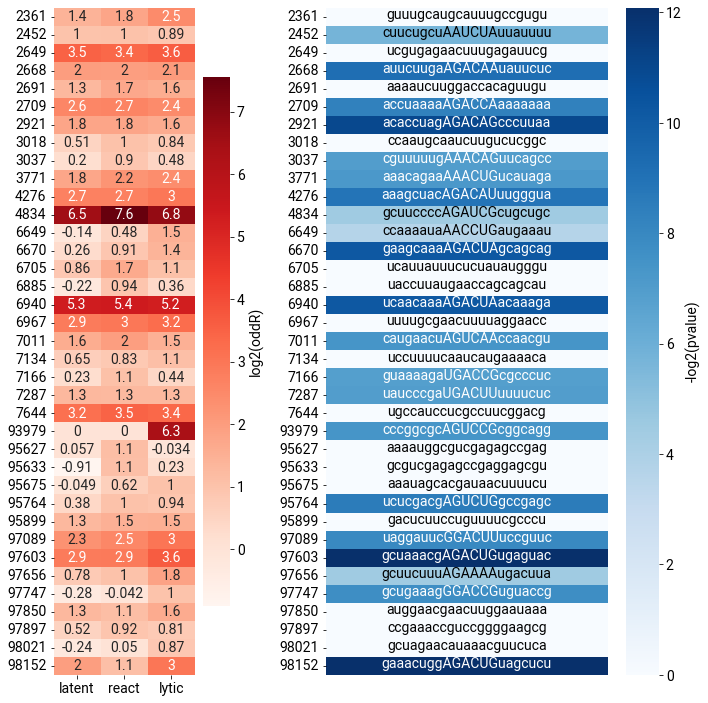

In [17]:
from matplotlib import colors
from matplotlib import cm
from scipy import stats

STRIDESIZE=10
def plot_heatmap():

    fig, axes = plt.subplots(1,2, figsize=(10,10),
                                gridspec_kw={'width_ratios':[1,2]})
    ax= axes[0]
    export_eligos2 = memealn.copy()
    export_eligos2 = export_eligos2.drop(6636)
    
    heatmap_df = export_eligos2.loc[:,'latent react lytic'.split(' ')]
    
    heatmap = np.array(heatmap_df)
    heatmap = np.where(heatmap==0, 1, heatmap)
    
    heatmap = np.log2(heatmap)
    sns.heatmap(pd.DataFrame(heatmap), ax=ax, cmap='Reds', cbar=True,
           yticklabels=heatmap_df.index, xticklabels=sample_names, annot=True,
           cbar_kws={'label':'log2(oddR)'})
    '''
    im = ax.imshow(heatmap, cmap='Reds')
    
    ax.set_yticks(np.arange(len(heatmap_df.index)))
    ax.set_xticks(np.arange(len(heatmap_df.columns)))
    
    ax.set_yticklabels(heatmap_df.index)
    ax.set_xticklabels(heatmap_df.columns)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    annotation = np.floor(heatmap*STRIDESIZE).astype(int) / STRIDESIZE
    
    for i in range(len(heatmap_df.index)):
        for j in range(len(heatmap_df.columns)):
            if annotation[i,j] >= 5:
                text = ax.text(j, i, annotation[i, j],
                               ha="center", va="center", color="w", fontsize=8)
            else:
                text = ax.text(j, i, annotation[i, j],
                               ha="center", va="center", color="black", fontsize=8)'''
    
                
                
    #fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=5), cmap='Reds'), 
    #fig.colorbar(im,
    #        ax=ax, orientation='vertical', fraction=.05,
    #        label='log2(oddR)')
    ax = axes[1]
    heatmap_df = export_eligos2.loc[:, 'pvalue'].fillna(1)
    
    #heatmap = np.array(heatmap_df)
    heatmap = -np.log2(heatmap_df)

    #heatmap = np.repeat(heatmap.reshape(38,1), 9, axis=1)
    sns.heatmap(pd.DataFrame(heatmap), ax=ax, cmap='Blues', cbar=True,
           xticklabels=False, yticklabels=heatmap.index,
                cbar_kws={'label':'-log2(pvalue)'})
    
    for i, (_, line) in enumerate(memealn.drop(6636).iterrows()):
        if line['newcontext']==0:
            context = line['originalcontext']
        else: context = line['newcontext']
        p = line['pvalue']
        if p<0.01:
            color='white'
        else: color='black'
        ax.text(.5, i, context, verticalalignment='top', 
                horizontalalignment='center', color=color, fontsize=14)
    ax.set_ylabel('')

        
    fig.tight_layout()
    return(fig, ax)
    
fig, ax = plot_heatmap()

/tmp/ipykernel_2503948/3441336015.py:25: RuntimeWarning: divide by zero encountered in log2
  heatbar = np.log2([build_heat_bar(plotdf, lnc)])
/tmp/ipykernel_2503948/3441336015.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.array(xticks+start, dtype=int))


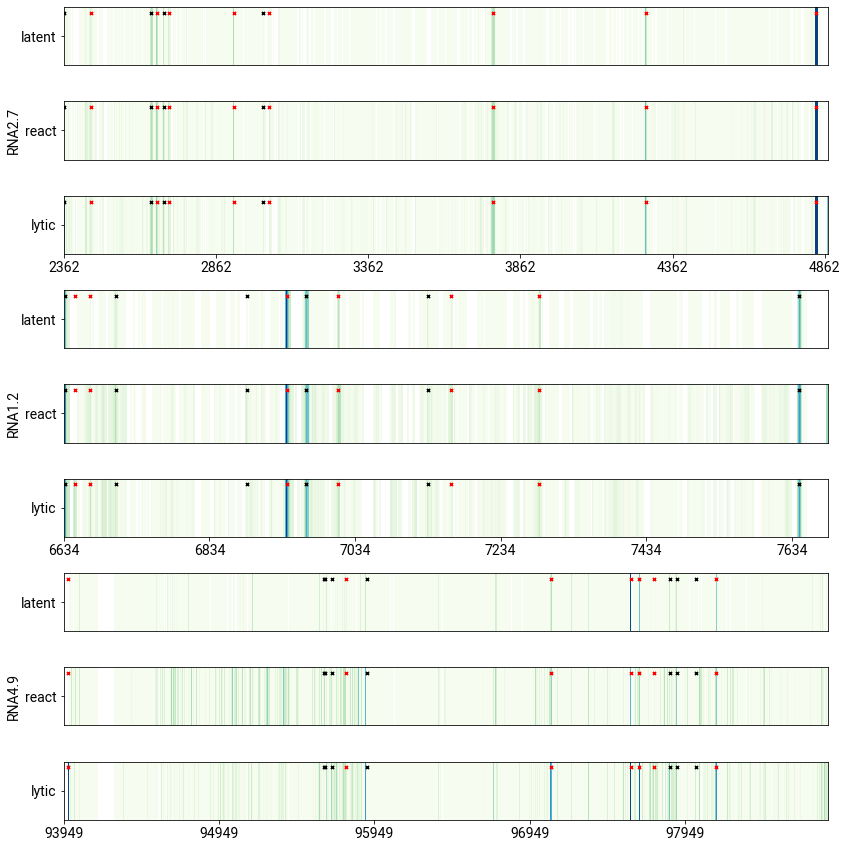

In [19]:
def build_heat_bar(df, lnc):
    lnclen = abs(lncanno.loc[lnc,'start'] - lncanno.loc[lnc, 'end']+1)
    heatbar = np.zeros(lnclen, np.float64)
    
    for _, line in df.iterrows():
        try:
            index = line['start_loc'] - lncanno.loc[lnc, 'start']
            heatbar[index] = line['oddR']
        except: continue
    return(heatbar)

fig, axes = plt.subplots(9,1, figsize=(12,12), facecolor='white')
for i, sample in enumerate(sample_names):
    for j, lnc in enumerate(lncanno.index[:-1]):

        
        start  = lncanno.loc[lnc, 'start']
        end = lncanno.loc[lnc, 'end']
        plotdf = modfracs.copy()
        plotdf = plotdf[(plotdf['name']==f'rna-{lnc}')
                       &(plotdf['sample']==sample)]
        plotdf = plotdf[plotdf['ESB_test']>=0.05]
        #heatbar  = pd.DataFrame(build_heat_bar(plotdf, lnc),
        #                       index=np.arange(start, end-1))
        heatbar = np.log2([build_heat_bar(plotdf, lnc)])
        ax = axes[i+j*3]
        
        if j!=2:
            cbar_ax = ax.pcolor(heatbar, vmin=0, vmax=5, cmap='GnBu',
                               )
            
        else:
            cbar_ax = ax.pcolor(heatbar, vmin=0, vmax=2, cmap='GnBu')
        ax.set_yticks([0.5])
        ax.set_yticklabels([sample])
        
        ax.set_xlim(0, end-start)
        meme = memealn[memealn['lnc']==lnc]
        meme_t = meme.dropna()
        meme_f = meme[meme['newcontext']==0]
        ax.scatter(meme_t.index-start, np.full(len(meme_t), 0.9), marker='x',
                  color='red', s=10)
        ax.scatter(meme_f.index-start, np.full(len(meme_f), 0.9), marker='x',
                  color='black', s=10)

        if i==1:
            ax.set_ylabel(lnc)
            
        if i!=2:
            
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.setp(ax.get_xticklines(), visible=False)

        else:
            #cax = plt.axes([0.85, 0.1, 0.075, 0.8])

            xticks=ax.get_xticks()
            ax.set_xticklabels(np.array(xticks+start, dtype=int))


        
        
#plt.subplots_adjust(hspace=1)       
plt.tight_layout()